# Merging Data

IMPORTANT: this version of the `melb_weather` DataFrame does not have the outliers removed

In [76]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import mean
from numpy import std
import scipy

In [77]:
#variable and file names
melb = 'monthly_rain','max_temp','min_temp'
melb_wide = ['data/monthly_rain_wide','data/max_temp_wide','data/min_temp_wide']
file_names = ["data/MelbourneRainfall.csv","data/MelbourneMaxTemp.csv","data/MelbourneMinTemp.csv"]

#loop for wide dataframes
for i in range(3):
    globals()[melb_wide[i]] = pd.read_csv(file_names[i],names = ['Product code', 'Station Number','Year',1,2,3,4,5,6,7,8,9,10,11,12,'Annual'])

#loop for melted dataframes
for i in range(3):
    globals()[melb[i]] = globals()[melb_wide[i]].set_index('Year').rename_axis('Month', axis=1).melt(value_vars=[1,2,3,4,5,6,7,8,9,10,11,12], ignore_index=False).rename({'value': melb[i]}, axis=1).reset_index(level=['Year'])
    globals()[melb[i]] = globals()[melb[i]][globals()[melb[i]]['Year']!='Year'].reset_index().drop('index',axis=1)
    globals()[melb[i]]['Year'] = pd.to_numeric(globals()[melb[i]]['Year'])


In [78]:
#variable and file names
drivers = ['dmi','newsam','nino','soi']
drivers_wide = ['data/dmi_wide','data/newsam_wide','data/nino_wide','data/soi_wide']
file_names = ['data/dmi.had.long.data.txt','data/newsam.1957.2007.txt','data/nino34.long.anom.data.txt','data/soi.txt']

#loop for wide dataframes
for i in range(4):
    globals()[drivers_wide[i]]=pd.read_csv(file_names[i], names = ['Year',1,2,3,4,5,6,7,8,9,10,11,12],delim_whitespace=True)
    
#loop for melted dataframes
for i in range(4):
    globals()[drivers[i]] = globals()[drivers_wide[i]].set_index('Year').rename_axis('Month', axis=1).melt(value_vars=[1,2,3,4,5,6,7,8,9,10,11,12], ignore_index=False).rename({'value': drivers[i]}, axis=1).reset_index(level=['Year'])
    if type(globals()[drivers[i]].iloc[0,1])!=np.float64:
        globals()[drivers[i]] = globals()[drivers[i]].iloc[1: , :]
        globals()[drivers[i]] = globals()[drivers[i]][globals()[drivers[i]]['Year']!='YEAR'].reset_index().drop('index',axis=1)
    globals()[drivers[i]]['Year'] = pd.to_numeric(globals()[drivers[i]]['Year'])

In [79]:
#merging dataframes
melb_weather = pd.merge(monthly_rain, max_temp,how='left').merge(min_temp,how='left').merge(dmi,how='left').merge(newsam,how='left').merge(nino,how='left').merge(soi,how='left').dropna(axis=0).reset_index().drop('index',axis=1)

melb_weather.dtypes

Year              int64
Month            object
monthly_rain     object
max_temp         object
min_temp         object
dmi             float64
newsam           object
nino            float64
soi              object
dtype: object

In [80]:
#adding a datetime column
melb_weather['Year']=melb_weather['Year'].map(str)
melb_weather['Month']=melb_weather['Month'].map(str)
melb_weather["Date"] = melb_weather["Year"]+ '-'+melb_weather["Month"]
melb_weather['Date'] = pd.to_datetime(melb_weather['Date'],format='%Y-%m')
melb_weather = melb_weather.sort_values(by="Date")
melb_weather = melb_weather[['Date','Year','Month','monthly_rain','max_temp','min_temp','dmi','newsam','nino','soi']].reset_index().drop('index',axis=1)

#making all values the same data type
for i in ['Year','Month','monthly_rain','max_temp','min_temp','newsam','soi']:
    melb_weather[i] = pd.to_numeric(melb_weather[i])

melb_weather

,Date,Year,Month,monthly_rain,max_temp,min_temp,dmi,newsam,nino,soi
0,1957-01-01,1957,1,6.8,25.8,11.8,-0.371,-0.87,-0.56,0.6
1,1957-02-01,1957,2,30.0,25.9,13.7,-0.484,-2.27,-0.24,-0.1
2,1957-03-01,1957,3,37.4,23.4,11.8,-0.097,0.07,0.08,0.2
3,1957-04-01,1957,4,29.4,20.7,10.1,-0.225,-1.97,0.42,0.2
4,1957-05-01,1957,5,44.2,16.8,8.0,-0.247,-2.50,0.45,-0.7
...,...,...,...,...,...,...,...,...,...,...
762,2020-08-01,2020,8,61.6,15.1,7.6,-0.070,-2.20,-0.42,1.1
763,2020-09-01,2020,9,33.6,18.1,9.8,-0.084,-0.25,-0.66,0.9
764,2020-10-01,2020,10,74.2,19.1,10.9,0.233,1.79,-1.19,0.5
765,2020-11-01,2020,11,48.8,24.5,14.0,0.143,1.14,-1.01,0.7


In [81]:
#calculating annual averages and creating a dataframe to store values
melb_climat = pd.DataFrame(index= melb_weather['Year'].unique(), columns = ['max_temp','min_temp','monthly_rain'])

for year in melb_weather['Year'].unique():
    max_temp_avg = melb_weather[melb_weather['Year']==year]['max_temp'].mean()
    min_temp_avg = melb_weather[melb_weather['Year']==year]['min_temp'].mean()
    monthly_rain_avg = melb_weather[melb_weather['Year']==year]['monthly_rain'].mean()
    melb_climat['max_temp'][year] = max_temp_avg
    melb_climat['min_temp'][year] = min_temp_avg
    melb_climat['monthly_rain'][year] = monthly_rain_avg
    
#updatting max_temp, min_temp and monthly_rainfall values to show anomalies
melb_anom = melb_weather.copy()

for year in melb_weather['Year'].unique():
    melb_anom.loc[melb_anom['Year']==year, 'max_temp']-=melb_climat['max_temp'][year]
    melb_anom.loc[melb_anom['Year']==year, 'min_temp']-=melb_climat['min_temp'][year]
    melb_anom.loc[melb_anom['Year']==year, 'monthly_rain']-=melb_climat['monthly_rain'][year]
melb_anom

,Date,Year,Month,monthly_rain,max_temp,min_temp,dmi,newsam,nino,soi
0,1957-01-01,1957,1,-37.391667,5.741667,2.266667,-0.371,-0.87,-0.56,0.6
1,1957-02-01,1957,2,-14.191667,5.841667,4.166667,-0.484,-2.27,-0.24,-0.1
2,1957-03-01,1957,3,-6.791667,3.341667,2.266667,-0.097,0.07,0.08,0.2
3,1957-04-01,1957,4,-14.791667,0.641667,0.566667,-0.225,-1.97,0.42,0.2
4,1957-05-01,1957,5,0.008333,-3.258333,-1.533333,-0.247,-2.50,0.45,-0.7
...,...,...,...,...,...,...,...,...,...,...
762,2020-08-01,2020,8,-3.966667,-4.775000,-3.641667,-0.070,-2.20,-0.42,1.1
763,2020-09-01,2020,9,-31.966667,-1.775000,-1.441667,-0.084,-0.25,-0.66,0.9
764,2020-10-01,2020,10,8.633333,-0.775000,-0.341667,0.233,1.79,-1.19,0.5
765,2020-11-01,2020,11,-16.766667,4.625000,2.758333,0.143,1.14,-1.01,0.7


# Exploring the difference in correlation between melb_anom and melb_weather

## Exploring the correlation in melb_weather

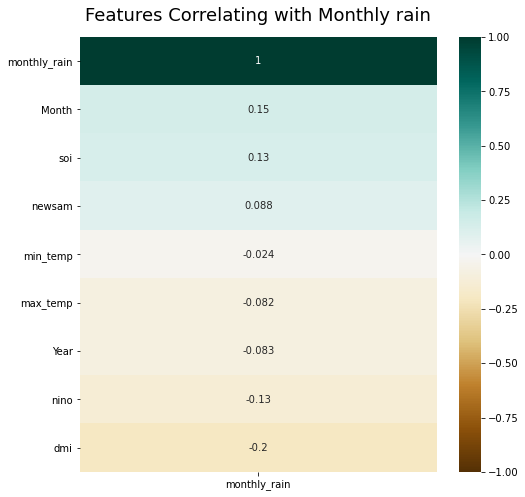

In [118]:
plt.figure(figsize=(8, 8))
heatmap = sns.heatmap(melb_weather.corr()[['monthly_rain']].sort_values(by='monthly_rain', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Monthly rain', fontdict={'fontsize':18}, pad=16);

Text(0.5, 1.0, 'melb_weather Correlation Heatmap')

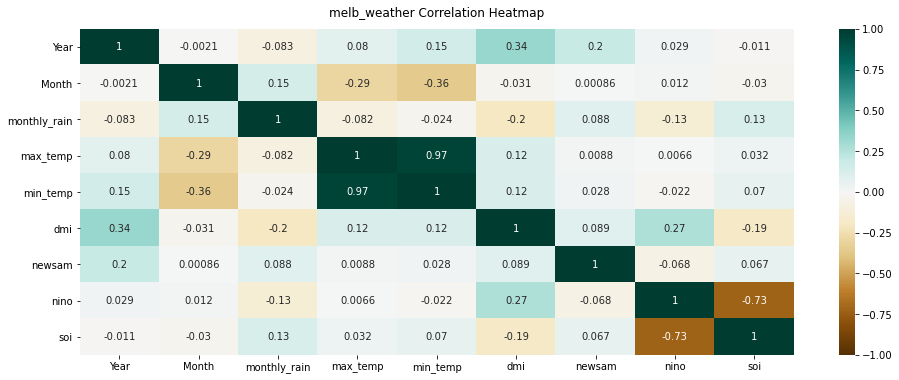

In [84]:
palette1= sns.diverging_palette(257, 255, s=300, l=50, n=14)
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(melb_weather.corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('melb_weather Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [85]:
correlations = melb_weather.corr()
print(correlations)

                  Year     Month  monthly_rain  max_temp  min_temp       dmi  \
Year          1.000000 -0.002116     -0.082733  0.080089  0.151668  0.335105   
Month        -0.002116  1.000000      0.145243 -0.294489 -0.358723 -0.030666   
monthly_rain -0.082733  0.145243      1.000000 -0.081971 -0.023990 -0.198665   
max_temp      0.080089 -0.294489     -0.081971  1.000000  0.967701  0.120187   
min_temp      0.151668 -0.358723     -0.023990  0.967701  1.000000  0.118226   
dmi           0.335105 -0.030666     -0.198665  0.120187  0.118226  1.000000   
newsam        0.195728  0.000855      0.087883  0.008774  0.027552  0.088953   
nino          0.028912  0.011840     -0.125015  0.006564 -0.021607  0.269421   
soi          -0.010651 -0.029875      0.130630  0.031827  0.069749 -0.185966   

                newsam      nino       soi  
Year          0.195728  0.028912 -0.010651  
Month         0.000855  0.011840 -0.029875  
monthly_rain  0.087883 -0.125015  0.130630  
max_temp      0.008

In [86]:
#  create a new dataframe with the correlated data from the anomalies dataframe
df2= melb_weather[['nino','soi','min_temp','max_temp', 'Month']]
df2

,nino,soi,min_temp,max_temp,Month
0,-0.56,0.6,11.8,25.8,1
1,-0.24,-0.1,13.7,25.9,2
2,0.08,0.2,11.8,23.4,3
3,0.42,0.2,10.1,20.7,4
4,0.45,-0.7,8.0,16.8,5
...,...,...,...,...,...
762,-0.42,1.1,7.6,15.1,8
763,-0.66,0.9,9.8,18.1,9
764,-1.19,0.5,10.9,19.1,10
765,-1.01,0.7,14.0,24.5,11


In [87]:
df2.corr(method ='kendall')

,nino,soi,min_temp,max_temp,Month
nino,1.000000,-0.516748,-0.018988,-0.005173,-0.001274
soi,-0.516748,1.000000,0.038305,0.017245,-0.044758
min_temp,-0.018988,0.038305,1.000000,0.848163,-0.212461
max_temp,-0.005173,0.017245,0.848163,1.000000,-0.172224
Month,-0.001274,-0.044758,-0.212461,-0.172224,1.000000


In [88]:
df2.corr(method ='spearman')

,nino,soi,min_temp,max_temp,Month
nino,1.000000,-0.695979,-0.030162,-0.009293,-0.000261
soi,-0.695979,1.000000,0.059108,0.029652,-0.060415
min_temp,-0.030162,0.059108,1.000000,0.968473,-0.339439
max_temp,-0.009293,0.029652,0.968473,1.000000,-0.287935
Month,-0.000261,-0.060415,-0.339439,-0.287935,1.000000


### Exploring the correlation between Max and Min temp

In [89]:
corr,pvalue = scipy.stats.pearsonr(df2['min_temp'], df2['max_temp']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  0.9677013662932092
P-value:  0.0


The function produced correlation coefficient 0.9677013662932092 that is close to 1, and it confirms a strong correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.

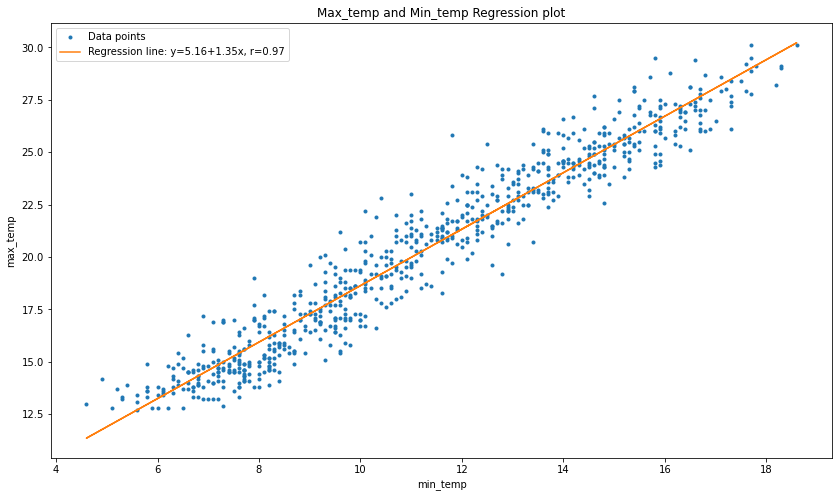

In [153]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df2['min_temp'], df2['max_temp'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df2['min_temp'], df2['max_temp'], linewidth=0, marker='.', label='Data points')
ax.plot(df2['min_temp'], intercept + slope * df2['min_temp'], label=line)
ax.set_xlabel('min_temp')
ax.set_ylabel('max_temp')
ax.legend(facecolor='white')
plt.title('Max_temp and Min_temp Regression plot')
plt.show()

### Exploring the correlation between Month and min_temp

In [91]:
scipy.stats.pearsonr(df2['Month'],df2['min_temp'])
corr,pvalue = scipy.stats.pearsonr(df2['min_temp'], df2['Month']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  -0.35872320413542874
P-value:  1.0446552568610767e-24


The function produced correlation coefficient -0.35872320413542874, that is close to 0, and it confirms a general negative correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.

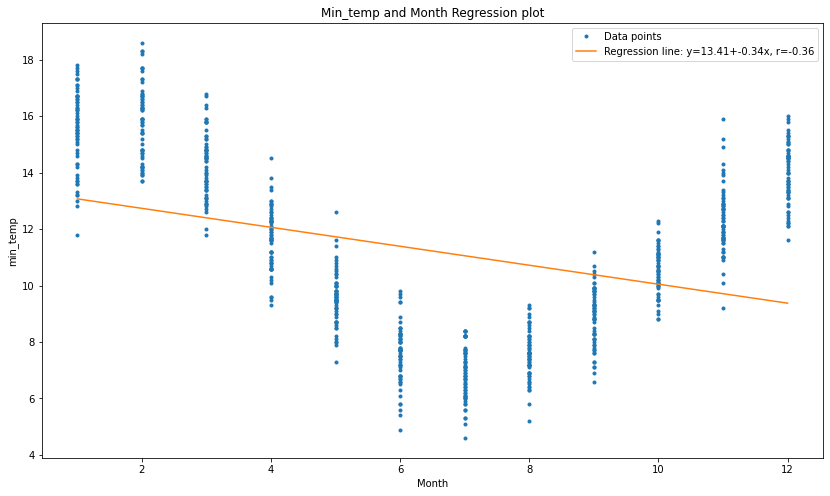

In [152]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df2['Month'], df2['min_temp'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df2['Month'], df2['min_temp'], linewidth=0, marker='.', label='Data points')
ax.plot(df2['Month'], intercept + slope * df2['Month'], label=line)
ax.set_xlabel('Month')
ax.set_ylabel('min_temp')
ax.legend(facecolor='white')
plt.title('Min_temp and Month Regression plot')
plt.show()

### Exploring the correlation between nino and soi

In [92]:
scipy.stats.pearsonr(df2['nino'],df2['soi'])
corr,pvalue = scipy.stats.pearsonr(df2['soi'], df2['nino']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  -0.7260369503275145
P-value:  1.539387961685675e-126


The function produced correlation coefficient -0.7260369503275145, that is close to -1, and it confirms a negative correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.

<AxesSubplot:xlabel='nino', ylabel='soi'>

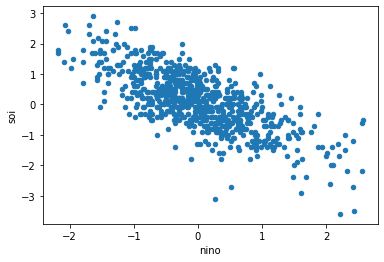

In [93]:
df2.plot.scatter(x='nino',y='soi')

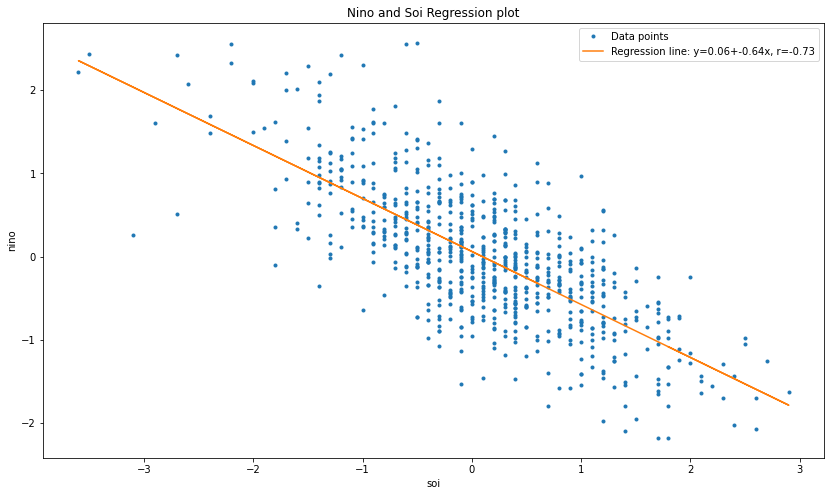

In [151]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df2['soi'], df2['nino'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df2['soi'], df2['nino'], linewidth=0, marker='.', label='Data points')
ax.plot(df2['soi'], intercept + slope * df2['soi'], label=line)
ax.set_xlabel('soi')
ax.set_ylabel('nino')
ax.legend(facecolor='white')
plt.title('Nino and Soi Regression plot')
plt.show()

#### The final findings are at the bottom of the notebook

# Exploring the correlation of melb_anom

In [96]:
#  create a new dataframe with the correlated data from the anomalies dataframe
df1= melb_anom[['nino','soi','min_temp','max_temp', 'Month']]
df1

,nino,soi,min_temp,max_temp,Month
0,-0.56,0.6,2.266667,5.741667,1
1,-0.24,-0.1,4.166667,5.841667,2
2,0.08,0.2,2.266667,3.341667,3
3,0.42,0.2,0.566667,0.641667,4
4,0.45,-0.7,-1.533333,-3.258333,5
...,...,...,...,...,...
762,-0.42,1.1,-3.641667,-4.775000,8
763,-0.66,0.9,-1.441667,-1.775000,9
764,-1.19,0.5,-0.341667,-0.775000,10
765,-1.01,0.7,2.758333,4.625000,11


In [98]:
correlations = melb_anom .corr()
print(correlations)

                      Year     Month  monthly_rain      max_temp  \
Year          1.000000e+00 -0.002116 -6.130775e-17 -3.123716e-16   
Month        -2.115901e-03  1.000000  1.549001e-01 -2.973410e-01   
monthly_rain -6.130775e-17  0.154900  1.000000e+00 -6.466462e-02   
max_temp     -3.123716e-16 -0.297341 -6.466462e-02  1.000000e+00   
min_temp     -2.580896e-16 -0.365103 -1.352761e-02  9.759410e-01   
dmi           3.351054e-01 -0.030666 -7.682295e-02  7.417899e-02   
newsam        1.957283e-01  0.000855  9.198841e-02 -1.087374e-02   
nino          2.891178e-02  0.011840 -3.641169e-02  1.288274e-02   
soi          -1.065055e-02 -0.029875  6.267912e-02  2.194211e-02   

                  min_temp       dmi    newsam      nino       soi  
Year         -2.580896e-16  0.335105  0.195728  0.028912 -0.010651  
Month        -3.651026e-01 -0.030666  0.000855  0.011840 -0.029875  
monthly_rain -1.352761e-02 -0.076823  0.091988 -0.036412  0.062679  
max_temp      9.759410e-01  0.074179 -0.010

Text(0.5, 1.0, 'melb_anom Correlation Heatmap')

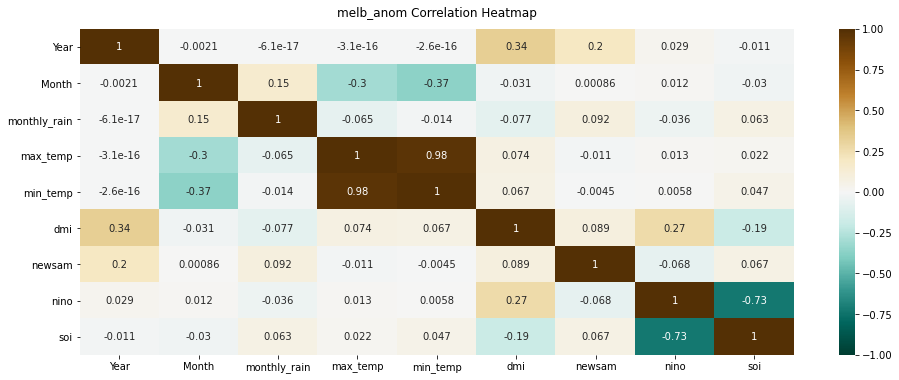

In [97]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(melb_anom .corr(), vmin=-1, vmax=1, annot=True,cmap='BrBG_r')
heatmap.set_title('melb_anom Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [99]:
type(df1)


pandas.core.frame.DataFrame

In [155]:
df1.corr(method = 'spearman')

,nino,soi,min_temp,max_temp,Month
nino,1.000000,-0.695979,-0.006465,-0.006888,-0.000261
soi,-0.695979,1.000000,0.040081,0.022760,-0.060415
min_temp,-0.006465,0.040081,1.000000,0.975982,-0.349920
max_temp,-0.006888,0.022760,0.975982,1.000000,-0.295421
Month,-0.000261,-0.060415,-0.349920,-0.295421,1.000000


Checking the correlation using kendall,spearman rank and pearson. 

In [101]:
df1.corr(method ='kendall')

,nino,soi,min_temp,max_temp,Month
nino,1.000000,-0.516748,-0.003387,-0.004325,-0.001274
soi,-0.516748,1.000000,0.024849,0.013305,-0.044758
min_temp,-0.003387,0.024849,1.000000,0.861375,-0.213537
max_temp,-0.004325,0.013305,0.861375,1.000000,-0.171491
Month,-0.001274,-0.044758,-0.213537,-0.171491,1.000000


In [102]:
df1.corr(method ='spearman')

,nino,soi,min_temp,max_temp,Month
nino,1.000000,-0.695979,-0.006465,-0.006888,-0.000261
soi,-0.695979,1.000000,0.040081,0.022760,-0.060415
min_temp,-0.006465,0.040081,1.000000,0.975982,-0.349920
max_temp,-0.006888,0.022760,0.975982,1.000000,-0.295421
Month,-0.000261,-0.060415,-0.349920,-0.295421,1.000000


I chose The Pearson correlation coefficient as it measures the linear relationship between two datasets.

The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so of which this dataset is.

### Exploring the correlation between max_temp and min_temp

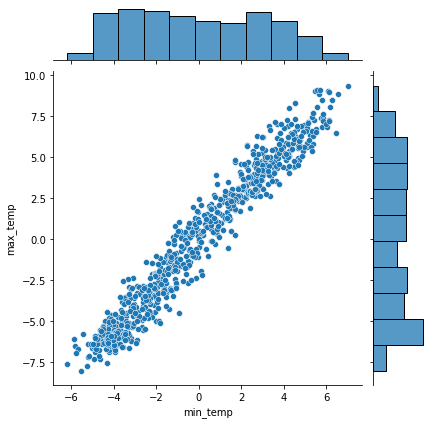

In [115]:
sns.jointplot(x = 'min_temp', y = 'max_temp', data = df1)

In [103]:
corr,pvalue = scipy.stats.pearsonr(df1['min_temp'], df1['max_temp']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  0.9759410185659803
P-value:  0.0


The function produced correlation coefficient 0.9759410185659803, that is close to 1, and it confirms a strong correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.

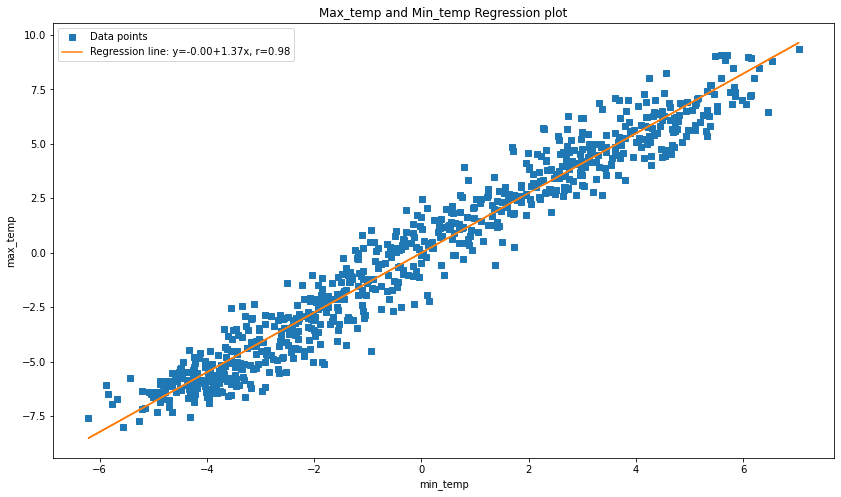

In [148]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df1['min_temp'], df1['max_temp'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df1['min_temp'], df1['max_temp'], linewidth=0, marker='s', label='Data points')
ax.plot(df1['min_temp'], intercept + slope * df1['min_temp'], label=line)
ax.set_xlabel('min_temp')
ax.set_ylabel('max_temp')
ax.legend(facecolor='white')
plt.title('Max_temp and Min_temp Regression plot')
plt.show()

### Exploring the correlation between Month and min_temp

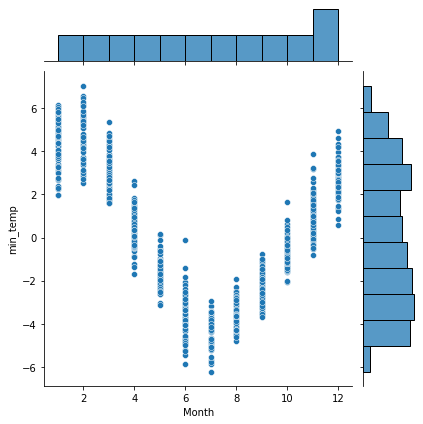

In [114]:
sns.jointplot(x = 'Month', y = 'min_temp', data = df1)

In [105]:
scipy.stats.pearsonr(df1['Month'],df1['min_temp'])
corr,pvalue = scipy.stats.pearsonr(df1['min_temp'], df1['Month']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  -0.365102580816332
P-value:  1.3451806606325532e-25


As expected, the function produced correlation coefficient -0.365102580816332, that is close to 0, and it confirms a negative correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.


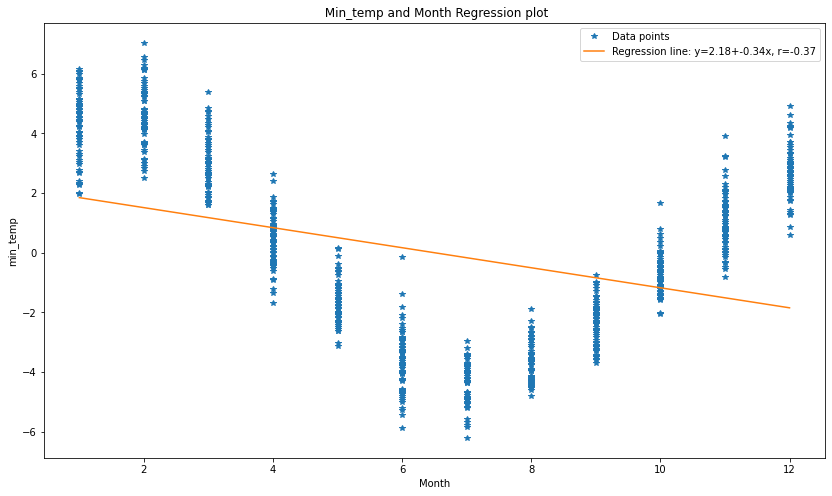

In [147]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df1['Month'], df1['min_temp'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df1['Month'], df1['min_temp'], linewidth=0, marker='*', label='Data points')
ax.plot(df1['Month'], intercept + slope * df1['Month'], label=line)
ax.set_xlabel('Month')
ax.set_ylabel('min_temp')
ax.legend(facecolor='white')
plt.title(' Min_temp and Month Regression plot')
plt.show()

##### Exploring the correlation between nino and soi

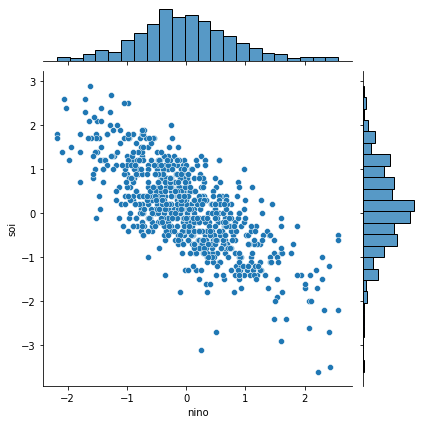

In [113]:
sns.jointplot(x = 'nino', y = 'soi', data = df1)

In [107]:
scipy.stats.pearsonr(df1['nino'],df1['soi'])
corr,pvalue = scipy.stats.pearsonr(df1['soi'], df1['nino']) 
print('Correlation coefficient: ', corr)
print('P-value: ', pvalue)

Correlation coefficient:  -0.7260369503275145
P-value:  1.539387961685675e-126


As expected, the function produced correlation coefficient -0.7260369503275145, that is close to -1, and it confirms a strong negative correlation. The returned p-value is < 0.001, and so it confirms strong certainty in the result.This is further seen in the regression plot below. 

<AxesSubplot:xlabel='nino', ylabel='soi'>

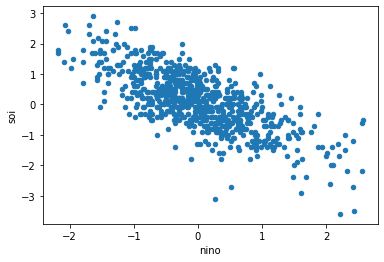

In [108]:
df1.plot.scatter(x='nino',y='soi')

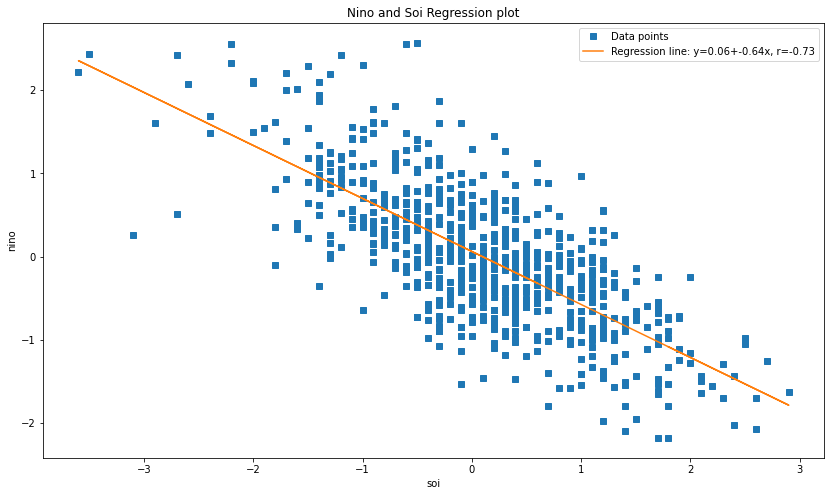

In [146]:
# creating X-Y Plots With a Regression Line

# slope, intersept, and correlation coefficient calculation 
slope, intercept, r, p, stderr = scipy.stats.linregress(df1['soi'], df1['nino'])

line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}'

# plotting
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(df1['soi'], df1['nino'], linewidth=0, marker='s', label='Data points')
ax.plot(df1['soi'], intercept + slope * df1['soi'], label=line)
ax.set_xlabel('soi')
ax.set_ylabel('nino')
ax.legend(facecolor='white')
plt.title('Nino and Soi Regression plot' )
plt.show()

# Findings. 
In melb_anom, the data is more correlated than in melb_weather. It is more correlated by 0.1.  This may be due to the included anomalies hence making the dataset larger. In melb_weather the only data that is correlated in any way is nino and soi (strong negative correlation), max_temp and min_temp (strong positive correlation) and Month and min_temp (generally negatively correlated).
Upon further investigation, it has been confirmed that there is certainty in the results. However, no conclusion was drawn as to why they are correlated. 